In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
from segmentation_utilities import *
import pandas as pd

# Load data

In [2]:
def load_data(images_dir):
    image_files = search_files(images_dir, pattern=r'sat.*\.tif$')
    label_files = search_files(images_dir, pattern=r'mask.*\.tif$')
    
    images = []
    labels = []
    
    for img_file, lbl_file in zip(image_files, label_files):
        img = read_raster(img_file, dtype=np.float32) / 255.0  # Normalise images between 0 and 1
        lbl = read_raster(lbl_file, dtype=np.float32)  # Set labels data type as float
        images.append(img)
        labels.append(lbl)
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [3]:
# Load training and validation data
images_train, labels_train = load_data('data/sentinal_training/train_downscaled')
images_valid, labels_valid = load_data('data/sentinal_training/valid_downscaled')

/Users/jonnycodd/anaconda3/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
# Print shapes to verify
print(f"Training images shape: {images_train.shape}")
print(f"Training labels shape: {labels_train.shape}")
print(f"Validation images shape: {images_valid.shape}")
print(f"Validation labels shape: {labels_valid.shape}")

Training images shape: (722, 128, 128, 3)
Training labels shape: (722, 128, 128, 3)
Validation images shape: (81, 128, 128, 3)
Validation labels shape: (81, 128, 128, 3)


# Understand classes

In [7]:
color_dict = pd.read_csv('data/sentinal_training/class_dict.csv')
color_dict

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


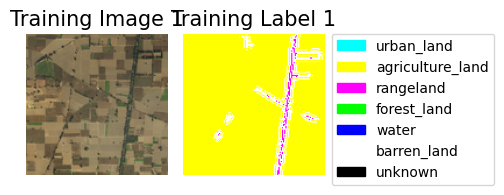

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


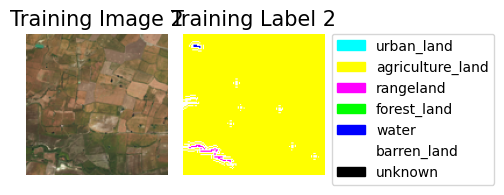

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


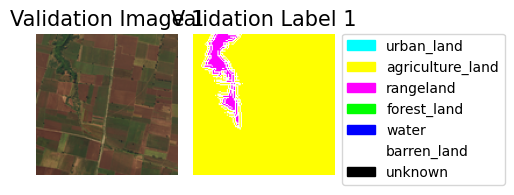

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


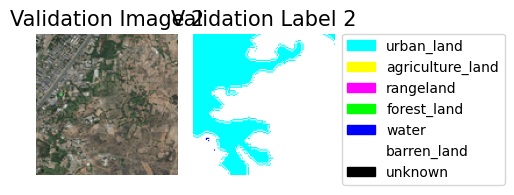

In [8]:


num_samples_to_display = 2  # Number of samples to display

for i in range(num_samples_to_display):
    image = images_train[i]
    label = labels_train[i]
    compare([image, label], titles=[f'Training Image {i+1}', f'Training Label {i+1}'])

# Display some sample images and corresponding labels from the validation set
for i in range(num_samples_to_display):
    image = images_valid[i]
    label = labels_valid[i]
    compare([image, label], titles=[f'Validation Image {i+1}', f'Validation Label {i+1}'])


# Build UNET

In [9]:
def build_unet_model(input_shape):
    '''Initialize a U-Net model for semantic segmentation with custom input/output shapes'''
    inputs = layers.Input(shape=input_shape)
    
    # Initializer
    initializer = initializers.HeNormal()

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottom of the U
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(c5)

    u6 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(u6)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(c6)

    u7 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(u7)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer=initializer, padding='same')(c7)

    # Output layer
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c7)  # Using 3 channels for output

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define the model parameters for your specific input shape
input_shape = (122, 122, 3)  # Custom input shape

# Build and compile the model
model = build_unet_model(input_shape)
model.summary()

# Optionally, visualize the model architecture
tf.keras.utils.plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)


: 